In [33]:
USE_TEX=True # Set to true to activate latex plots. This requires an installed latex distribution on the device
SAVE_PLOTS=True # whether to save the plots created in this notebook
SAVE_TABLES=True # whether to save the tables created in this notebook

In [34]:
#Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import sys,os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
from IPython.display import display, clear_output

if USE_TEX: #activate tex for pyplot
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
    })

#Add the repo root (one level up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
#Install necessary resources from nltk
import nltk

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to C:\Users\Philipp
[nltk_data]     Hoffmann\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Philipp Hoffmann\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to C:\Users\Philipp
[nltk_data]     Hoffmann\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 1. Download data

In [36]:
import kagglehub

#Download latest version of dataset
print("Load or download dataset...")
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset") #path to downloaded dataset
#   (if already downloaded, will not download again)

fake_path=os.path.join(path, "Fake.csv")    #path to dataset with true news
true_path=os.path.join(path, "True.csv")    #path to dataset with fake news

#Read into dataframes
print("Loading fake.csv ...")
fake_df=pd.read_csv(fake_path)
print("Loading true.csv ...")
true_df=pd.read_csv(true_path)

#Label data (1=true, 0=fakenews)
true_df['label']=1
fake_df['label']=0

#Join dataframes
df=pd.concat([true_df, fake_df])
print("Done")


Load or download dataset...
Loading fake.csv ...
Loading true.csv ...
Done


## 2. Preprocess data

In [37]:
from courselib.utils.splits import train_test_split

training_data_fraction=.8

#Split
df_, train_df, test_df=train_test_split(df, training_data_fraction=training_data_fraction, class_column_name='label', return_numpy=False)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from courselib.utils.normalization import standardize_sparse_matrix

column='title' #column of df to vectorize


#Vectorize
vectorizer=TfidfVectorizer()
X_train=vectorizer.fit_transform((train_df[column]))
X_test=vectorizer.transform((test_df[column]))
X=sp.vstack([X_train, X_test])

Y_train=train_df['label'].to_numpy()
Y_test=test_df['label'].to_numpy()

#-1, 1 labels for SVM
Y_train_neg=Y_train.copy()
Y_train_neg[Y_train_neg==0]=-1
Y_test_neg=Y_test.copy()
Y_test_neg[Y_test_neg==0]=-1

#Apply additional z-score normalization (worked better for svm)
X, offset=standardize_sparse_matrix(X)
X_train, X_test=X[:len(train_df)], X[len(train_df):]

In [39]:
num_features=X_train.shape[1] #number of extracted features from train_df[column]
print(f"{num_features} features were extracted from column {column} of the test dataframe.")

19562 features were extracted from column title of the test dataframe.


## 3. Comparison of different models

In [40]:
from courselib.models.glm import LogisticRegression
from courselib.models.svm import LinearSVM, BinaryKernelSVM
from courselib.optimizers import GDOptimizer

lr_LR=10 #learning rate LogisticRegression model
lr_SVM=0.001 #learning rate LinearSVM model

#Initialize optimizers
optimizer_LR=GDOptimizer(lr_LR) #optimizer LogisticRegression
optimizer_SVM=GDOptimizer(lr_SVM) #optimizer LinearSVM



In [41]:
import time
from courselib.utils.metrics import binary_accuracy, precision, recall, f1_score

num_epochs=100 #number of epochs
bs=len(train_df) #batch size (here full batch)

results=[]


#Initialize models
w=np.zeros(num_features) #initial weight
b=0 #initial bias
model_LR=LogisticRegression(w,b, optimizer=optimizer_LR, offset=offset)
model_SVM=LinearSVM(w,b, optimizer=optimizer_SVM, offset=offset)

#Training:
metrics_dict_LR={'train accuracy': lambda y_pred,y_true: binary_accuracy(y_pred=y_pred, y_true=y_true, class_labels=[0,1]),
                'test accuracy': lambda y_pred,y_true: binary_accuracy(model_LR.decision_function(X_test),Y_test,class_labels=[0,1])}
metrics_dict_SVM={'train accuracy': lambda y_pred,y_true: binary_accuracy(y_pred=y_pred, y_true=y_true, class_labels=[-1,1]),
                'test accuracy': lambda y_pred,y_true: binary_accuracy(model_SVM.decision_function(X_test),Y_test_neg,class_labels=[-1,1])}

start_LR=time.time()
metrics_history_LR=model_LR.fit(X_train, Y_train, num_epochs=num_epochs, batch_size=bs, compute_metrics=True, metrics_dict=metrics_dict_LR)
end_LR=time.time()

start_SVM=time.time() #measure training time
metrics_history_SVM=model_SVM.fit(X_train, Y_train_neg, num_epochs=num_epochs, batch_size=bs, compute_metrics=True, metrics_dict=metrics_dict_SVM)
end_SVM=time.time()


results.append({'model':'Logistic Regression', 'batch size': 'full' if bs==len(train_df) else bs,
         'train accuracy [pct.]':round(metrics_history_LR['train accuracy'][-1],2),
         'test accuracy [pct.]':round(metrics_history_LR['test accuracy'][-1],2), 'training time [s]': round(end_LR-start_LR,2), 
         'test precision': round(precision(model_LR(X_test), Y_test),2), 
         'test recall': round(recall(model_LR(X_test), Y_test),2), 
         'test f1-score': round(f1_score(model_LR(X_test), Y_test),2)
         })
results.append({'model':'Linear SVM', 'batch size': 'full' if bs==len(train_df) else bs,
              'train accuracy [pct.]':round(metrics_history_SVM['train accuracy'][-1],2),
              'test accuracy [pct.]':round(metrics_history_SVM['test accuracy'][-1],2), 'training time [s]': round(end_SVM-start_SVM,2),
              'test precision': round(precision(model_SVM(X_test), Y_test_neg),2), 
              'test recall': round(recall(model_SVM(X_test), Y_test_neg),2), 
              'test f1-score': round(f1_score(model_SVM(X_test), Y_test_neg),2)
         })
results_df=pd.DataFrame(results)
results_df

,model,batch size,train accuracy [pct.],test accuracy [pct.],training time [s],test precision,test recall,test f1-score
0,Logistic Regression,full,100.00,95.56,0.68,0.95,0.96,0.95
1,Linear SVM,full,99.38,95.42,0.91,0.94,0.96,0.95


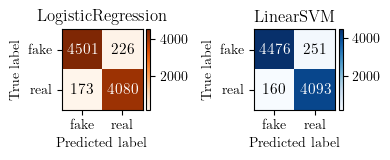

In [42]:
from courselib.utils.metrics import binary_confusion_matrix, plot_confusion_matrix

# Plot confusion matrices:

fig,ax=plt.subplots(1,2, figsize=(4,3)) #Revert
plot_confusion_matrix(binary_confusion_matrix(y_true=Y_test, y_pred=model_LR(X_test), plot=False),ax=ax[0], cmap='Oranges', show_plt=False, class_names=['fake', 'real'], rotation=0, ha='center')
plot_confusion_matrix(binary_confusion_matrix(y_true=Y_test_neg, y_pred=model_SVM(X_test), plot=False, labels=[-1,1]),cmap='Blues',ax=ax[1], show_plt=False,class_names=['fake', 'real'], rotation=0, ha='center')
ax[0].set_title('LogisticRegression')
ax[1].set_title('LinearSVM')
plt.tight_layout()
# plt.suptitle("Confusion Matrices", fontsize=15)
plt.subplots_adjust(top=.9)
if SAVE_PLOTS: # save figure
    plt.savefig('figures/model_comparison_confusion_matrices.pdf', format='pdf')
plt.show()

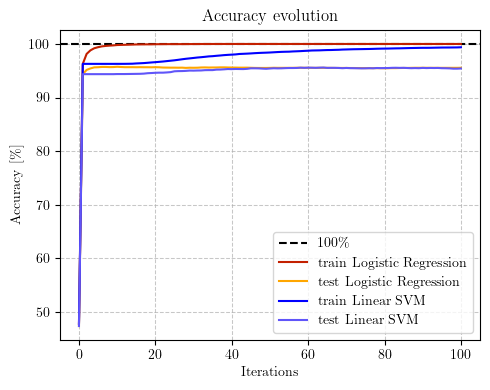

In [43]:
#Plot
fig,ax=plt.subplots(figsize=(5,4))
ax.axhline(y=100, color='black', linestyle='--', label='100\%') #horizontal line at 100%
ax.plot(range(len(metrics_history_LR['train accuracy'])),metrics_history_LR['train accuracy'], label="train Logistic Regression", color="#C32000")
ax.plot(range(len(metrics_history_LR['test accuracy'])),metrics_history_LR['test accuracy'], label="test Logistic Regression", color="#FFA600")
ax.plot(range(len(metrics_history_SVM['train accuracy'])),metrics_history_SVM['train accuracy'], label="train Linear SVM", color="#0000FF")
ax.plot(range(len(metrics_history_SVM['test accuracy'])),metrics_history_SVM['test accuracy'], label="test Linear SVM", color="#6055F9")

# Turn on minor ticks
# ax.minorticks_on()
ax.grid(which='major', linestyle='--', linewidth=0.75, alpha=.7)
# ax.grid(which='minor', linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)

ax.legend()
ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy [\%]')
ax.set_title('Accuracy evolution')

plt.tight_layout()
if SAVE_PLOTS: # save figure
    plt.savefig('figures/model_comparison_accuracy_evolution.pdf', format='pdf')


### 3.1. Comparison with mini batch

In [44]:
bs=100 #mini batch size to compare
lr_LR2=0.01 #learning rate LogisticRegression model (this learning rate performed better for mini batch)
lr_SVM2=0.001 #learning rate LinearSVM model

#Initialize optimizers
optimizer_LR2=GDOptimizer(lr_LR2) #optimizer LogisticRegression
optimizer_SVM2=GDOptimizer(lr_SVM2) #optimizer LinearSVM

#Initialize models
model_LR2=LogisticRegression(w,b, optimizer=optimizer_LR2, offset=offset)
model_SVM2=LinearSVM(w,b, optimizer=optimizer_SVM2, offset=offset)

#Train
start_LR2=time.time()
model_LR2.fit(X_train, Y_train, num_epochs=num_epochs, batch_size=bs)
end_LR2=time.time()

start_SVM2=time.time()
model_SVM2.fit(X_train, Y_train_neg, num_epochs=num_epochs, batch_size=bs)
end_SVM2=time.time()

#Save results
results.append({'model':'Logistic Regression', 'batch size': 'full' if bs==len(train_df) else bs,
       'train accuracy [pct.]':round(binary_accuracy(model_LR2(X_train), Y_train, class_labels=[0,1]),2),
       'test accuracy [pct.]':round(binary_accuracy(model_LR2(X_test), Y_test, class_labels=[0,1]),2), 
       'training time [s]': round(end_LR2-start_LR2,2),
       'test precision': round(precision(model_LR2(X_test), Y_test),2), 
       'test recall': round(recall(model_LR2(X_test), Y_test),2), 
       'test f1-score': round(f1_score(model_LR2(X_test), Y_test),2)
       
       })
results.append({'model':'Linear SVM', 'batch size': 'full' if bs==len(train_df) else bs,
       'train accuracy [pct.]':round(binary_accuracy(model_SVM2(X_train), Y_train_neg, class_labels=[-1,1]),2),
       'test accuracy [pct.]':round(binary_accuracy(model_SVM2(X_test), Y_test_neg, class_labels=[-1,1]),2), 
       'training time [s]': round(end_SVM2-start_SVM2,2),
       'test precision': round(precision(model_SVM2(X_test), Y_test),2), 
       'test recall': round(recall(model_SVM2(X_test), Y_test),2), 
       'test f1-score': round(f1_score(model_SVM2(X_test), Y_test),2)
       })

results_df=pd.DataFrame(results)
if SAVE_TABLES:
       results_df.to_csv('tables/model_comparison_table.csv', index=False)
results_df

,model,batch size,train accuracy [pct.],test accuracy [pct.],training time [s],test precision,test recall,test f1-score
0,Logistic Regression,full,100.00,95.56,0.68,0.95,0.96,0.95
1,Linear SVM,full,99.38,95.42,0.91,0.94,0.96,0.95
2,Logistic Regression,100,100.00,95.19,9.20,0.94,0.96,0.95
3,Linear SVM,100,96.59,92.19,23.95,0.91,0.92,0.92


## 4. Vectorization and Tokenization Comparison

### 4.1 Performance with different numbers of features

In [45]:
from courselib.utils.preprocessing import multi_column_vectorizer

num_features=[1,10, 100, 500]+list(range(1000, 20000,1000))+[None] # list of (maximal) features to compare (None=all features)
columns=['title'] #list of the columns to vectorize (as list for our custom multi_column_vectorizer)

lr=10 # learning rate
epochs=100 # epochs
bs=len(train_df) #batch size (from now on only full batch)

#Initialize optimizer
optimizer=GDOptimizer(lr) 

In [46]:
train_accuracies=[]
test_accuracies=[]

for n in num_features:
     # Vectorize
     vectorizer=multi_column_vectorizer(col_names=columns,max_features_per_column=n)
     X_train=vectorizer.fit_transform(train_df)
     X_test=vectorizer.transform(test_df)
     X=sp.vstack([X_train, X_test])

     #Apply additional z-score normalization (works better for svm)
     X, offset=standardize_sparse_matrix(X)
     X_train, X_test=X[:len(train_df)], X[len(train_df):]

     #Initialize model
     w=np.zeros(X_train.shape[1])
     b=0
     model=LogisticRegression(w,b, optimizer=optimizer, offset=offset)

     #Train
     model.fit(X_train, Y_train, num_epochs=epochs, batch_size=bs)

     #Add results
     train_accuracies.append(binary_accuracy(y_pred=model(X_train), y_true=Y_train, class_labels=[0,1]))
     test_accuracies.append(binary_accuracy(y_pred=model(X_test), y_true=Y_test, class_labels=[0,1]))

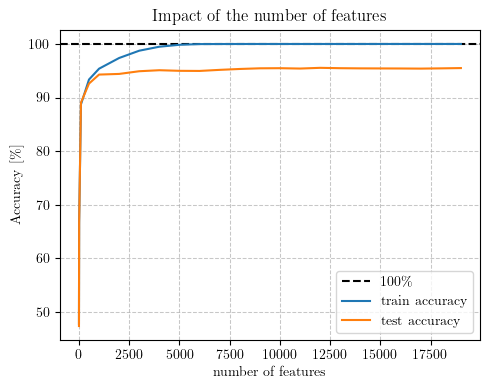

In [47]:
#Plot
fig,ax=plt.subplots(figsize=(5,4))
ax.axhline(y=100, color='black', linestyle='--', label='100\%') #horizontal line at 100%
ax.plot(num_features,train_accuracies, label="train accuracy")
ax.plot(num_features,test_accuracies, label="test accuracy")

ax.grid(which='major', linestyle='--', linewidth=0.75, alpha=.7)

ax.legend()
ax.set_xlabel('number of features')
ax.set_ylabel('Accuracy [\%]')
ax.set_title('Impact of the number of features')

plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig('figures/vectorization_comparison_feature_number_impact.pdf', format='pdf')
plt.show()


### 4.2 Training on title, text and both

In [48]:
columns_list=[['title'], ['text'], ['title', 'text']]
lrs=[10,0.1,0.1]

results_column_comparison=[]

for i,columns in enumerate(columns_list):
    #Vectorize
    vect_start=time.time()
    vectorizer=multi_column_vectorizer(col_names=columns)
    X_train=vectorizer.fit_transform(train_df)
    X_test=vectorizer.transform(test_df)
    X=sp.vstack([X_train, X_test])

    #Apply additional z-score normalization (works better for svm)
    X, offset=standardize_sparse_matrix(X)
    X_train, X_test=X[:len(train_df)], X[len(train_df):]
    vect_end=time.time()
    
    #initalize optimizer:
    optimizer=GDOptimizer(lrs[i])
    #Initialize model
    w=np.zeros(X_train.shape[1])
    b=0
    model=LogisticRegression(w,b, optimizer=optimizer, offset=offset)

    #Train
    train_start=time.time()
    model.fit(X_train, Y_train, num_epochs=epochs, batch_size=bs)
    train_end=time.time()

    # Results
    train_accuracy=round(binary_accuracy(y_pred=model(X_train), y_true=Y_train, class_labels=[0,1]),2)
    test_accuracy=round(binary_accuracy(y_pred=model(X_test), y_true=Y_test, class_labels=[0,1]),2)
    num_features=X_train.shape[1]

    results_column_comparison.append({
        'data':'+'.join(columns), 'learning rate': lrs[i],'number of features': num_features,
            'train accuracy [pct.]':train_accuracy, 'test accuracy [pct.]': test_accuracy,
            'vectorization time [s]': round(vect_end-vect_start,2),
            'training time [s]': round(train_end-train_start,2)
    })
    # display updating results
    results_column_comparison_df=pd.DataFrame(results_column_comparison)
    clear_output(wait=True)
    display(results_column_comparison_df)
    
if SAVE_TABLES: #save table
    results_column_comparison_df.to_csv('tables/vectorization_more_text_data.csv', index=False)
    

,data,learning rate,number of features,train accuracy [pct.],test accuracy [pct.],vectorization time [s],training time [s]
0,title,10.0,19562,100.00,95.56,0.56,0.52
1,text,0.1,111364,99.98,98.44,11.71,4.14
2,title+text,0.1,130926,100.00,98.95,12.21,4.56


### 4.3 Influence of different vectorizations

In [49]:
from courselib.utils.preprocessing import basic_word_tokenizer, stemming_tokenizer, lemmatization_tokenizer

tokenizers={'default': None, 'basic': basic_word_tokenizer, 'stemming': stemming_tokenizer, 'lemmatization':lemmatization_tokenizer } #tokenizers to compare
vectorization_types=['tf-idf', 'bag-of-words'] #vectorization types to compare
stop_words=[None, 'english'] # stop words to remove for comparison
columns=['title'] #list of the columns to vectorize (as list for our custom multi_column_vectorizer)

lr=10 # learning rate
epochs=100 # epochs
bs=len(train_df) #batch size (from now on only full batch)

#Initialize optimizer
optimizer=GDOptimizer(lr) 

In [50]:
results_vectorization=[]

for vt in vectorization_types:
    for sw in stop_words:
        for tk_name, tk in tokenizers.items():
            # Vectorize
            vect_start=time.time()
            vectorizer=multi_column_vectorizer(col_names=columns,vectorization=vt, stop_words=sw, tokenizer=tk)
            X_train=vectorizer.fit_transform(train_df)
            X_test=vectorizer.transform(test_df)
            X=sp.vstack([X_train, X_test])

            # Apply additional z-score normalization
            X, offset=standardize_sparse_matrix(X)
            X_train, X_test=X[:len(train_df)], X[len(train_df):]
            vect_end=time.time()

            # Initialize model
            w=np.zeros(X_train.shape[1])
            b=0
            model=LogisticRegression(w,b, optimizer=optimizer, offset=offset)

            # Train
            model.fit(X_train, Y_train, num_epochs=epochs, batch_size=bs)

            train_accuracy=round(binary_accuracy(y_pred=model(X_train), y_true=Y_train, class_labels=[0,1]),2)
            test_accuracy=round(binary_accuracy(y_pred=model(X_test), y_true=Y_test, class_labels=[0,1]),2)
            num_features=X_train.shape[1]

            #Add results
            results_vectorization.append({
                'vectorization type': vt, 'stop words': str(sw), 'tokenizer':tk_name,'number of features': num_features,
                'train accuracy [pct.]':train_accuracy, 'test accuracy [pct.]': test_accuracy,
                'precision test': round(precision(model(X_test), Y_test),2), 
                'recall test': round(recall(model(X_test), Y_test),2), 
                'f1-score test': round(f1_score(model(X_test), Y_test),2),
                'vectorization time [s]': round(vect_end-vect_start,2)
            })
            
            # display updating results
            results_vectorization_df=pd.DataFrame(results_vectorization)
            clear_output(wait=True)
            display(results_vectorization_df)

if SAVE_TABLES: #save results 
    results_vectorization_df.to_csv('tables/vectorization_comparison_table.csv', index=False)

,vectorization type,stop words,tokenizer,number of features,train accuracy [pct.],test accuracy [pct.],precision test,recall test,f1-score test,vectorization time [s]
0,tf-idf,None,default,19562,100.0,95.56,0.95,0.96,0.95,0.58
1,tf-idf,None,basic,24897,100.0,96.65,0.96,0.97,0.96,5.04
2,tf-idf,None,stemming,17293,100.0,96.49,0.96,0.97,0.96,11.57
3,tf-idf,None,lemmatization,20847,100.0,96.71,0.96,0.97,0.97,33.72
4,tf-idf,english,default,19288,100.0,94.40,0.94,0.95,0.94,0.57
5,tf-idf,english,basic,24625,100.0,95.90,0.95,0.96,0.96,5.02
6,tf-idf,english,stemming,17154,100.0,95.57,0.95,0.96,0.95,10.52
7,tf-idf,english,lemmatization,20799,100.0,95.97,0.96,0.96,0.96,29.79
8,bag-of-words,None,default,19562,100.0,95.59,0.95,0.96,0.95,0.57
9,bag-of-words,None,basic,24897,100.0,96.69,0.96,0.97,0.97,5.03


### 4.4 Influence of n-grams

In [51]:
ngram_ranges=[(1,1), (1,2), (1,3),(2,2), (3,3)] # ngrams to compare: unigrams only, unigrams+bigrams, unigrams+bigrams+trigrams, bigrams only, trigrams only

In [52]:
results_ngram=[]
vectorizers={} # collect trained vectorizers for evaluation of important words below 
weights={} # collect weights of the models for evaluation of important words below 

for ngram in ngram_ranges:
    #Vectorize
    vect_start=time.time()
    vectorizer=multi_column_vectorizer(col_names=columns,ngram_range=ngram)
    X_train=vectorizer.fit_transform(train_df)
    X_test=vectorizer.transform(test_df)
    X=sp.vstack([X_train, X_test])

    #Apply additional z-score normalization (works better for svm)
    X, offset=standardize_sparse_matrix(X)
    X_train, X_test=X[:len(train_df)], X[len(train_df):]
    vect_end=time.time()
    vectorizers.update({ngram: vectorizer})

    #Initialize model
    w=np.zeros(X_train.shape[1])
    b=0
    model=LogisticRegression(w,b, optimizer=optimizer, offset=offset)

    #Train
    train_start=time.time()
    model.fit(X_train, Y_train, num_epochs=epochs, batch_size=bs)
    train_end=time.time()

    train_accuracy=round(binary_accuracy(y_pred=model(X_train), y_true=Y_train, class_labels=[0,1]),2)
    test_accuracy=round(binary_accuracy(y_pred=model(X_test), y_true=Y_test, class_labels=[0,1]),2)
    num_features=X_train.shape[1]
    weights.update({ngram:model.w})
    

    #Add results
    results_ngram.append({
        'ngram range':'-'.join([str(s) for s in ngram]),'number of features': num_features,
            'train accuracy [pct.]':train_accuracy, 'test accuracy [pct.]': test_accuracy,
            'vectorization time [s]': round(vect_end-vect_start,2), 
            'training time [s]': round(train_end-train_start,2)
    })
    results_ngram_df=pd.DataFrame(results_ngram)
    clear_output(wait=True)
    display(results_ngram_df)
    
if SAVE_TABLES: #save
    results_ngram_df.to_csv('tables/comparison_ngrams.csv', index=False)

,ngram range,number of features,train accuracy [pct.],test accuracy [pct.],vectorization time [s],training time [s]
0,1-1,19562,100.0,95.56,0.55,0.51
1,1-2,211984,100.0,95.60,1.55,0.99
2,1-3,495860,100.0,93.92,2.71,1.56
3,2-2,192422,100.0,91.80,1.22,0.72
4,3-3,283876,100.0,71.71,1.38,0.83


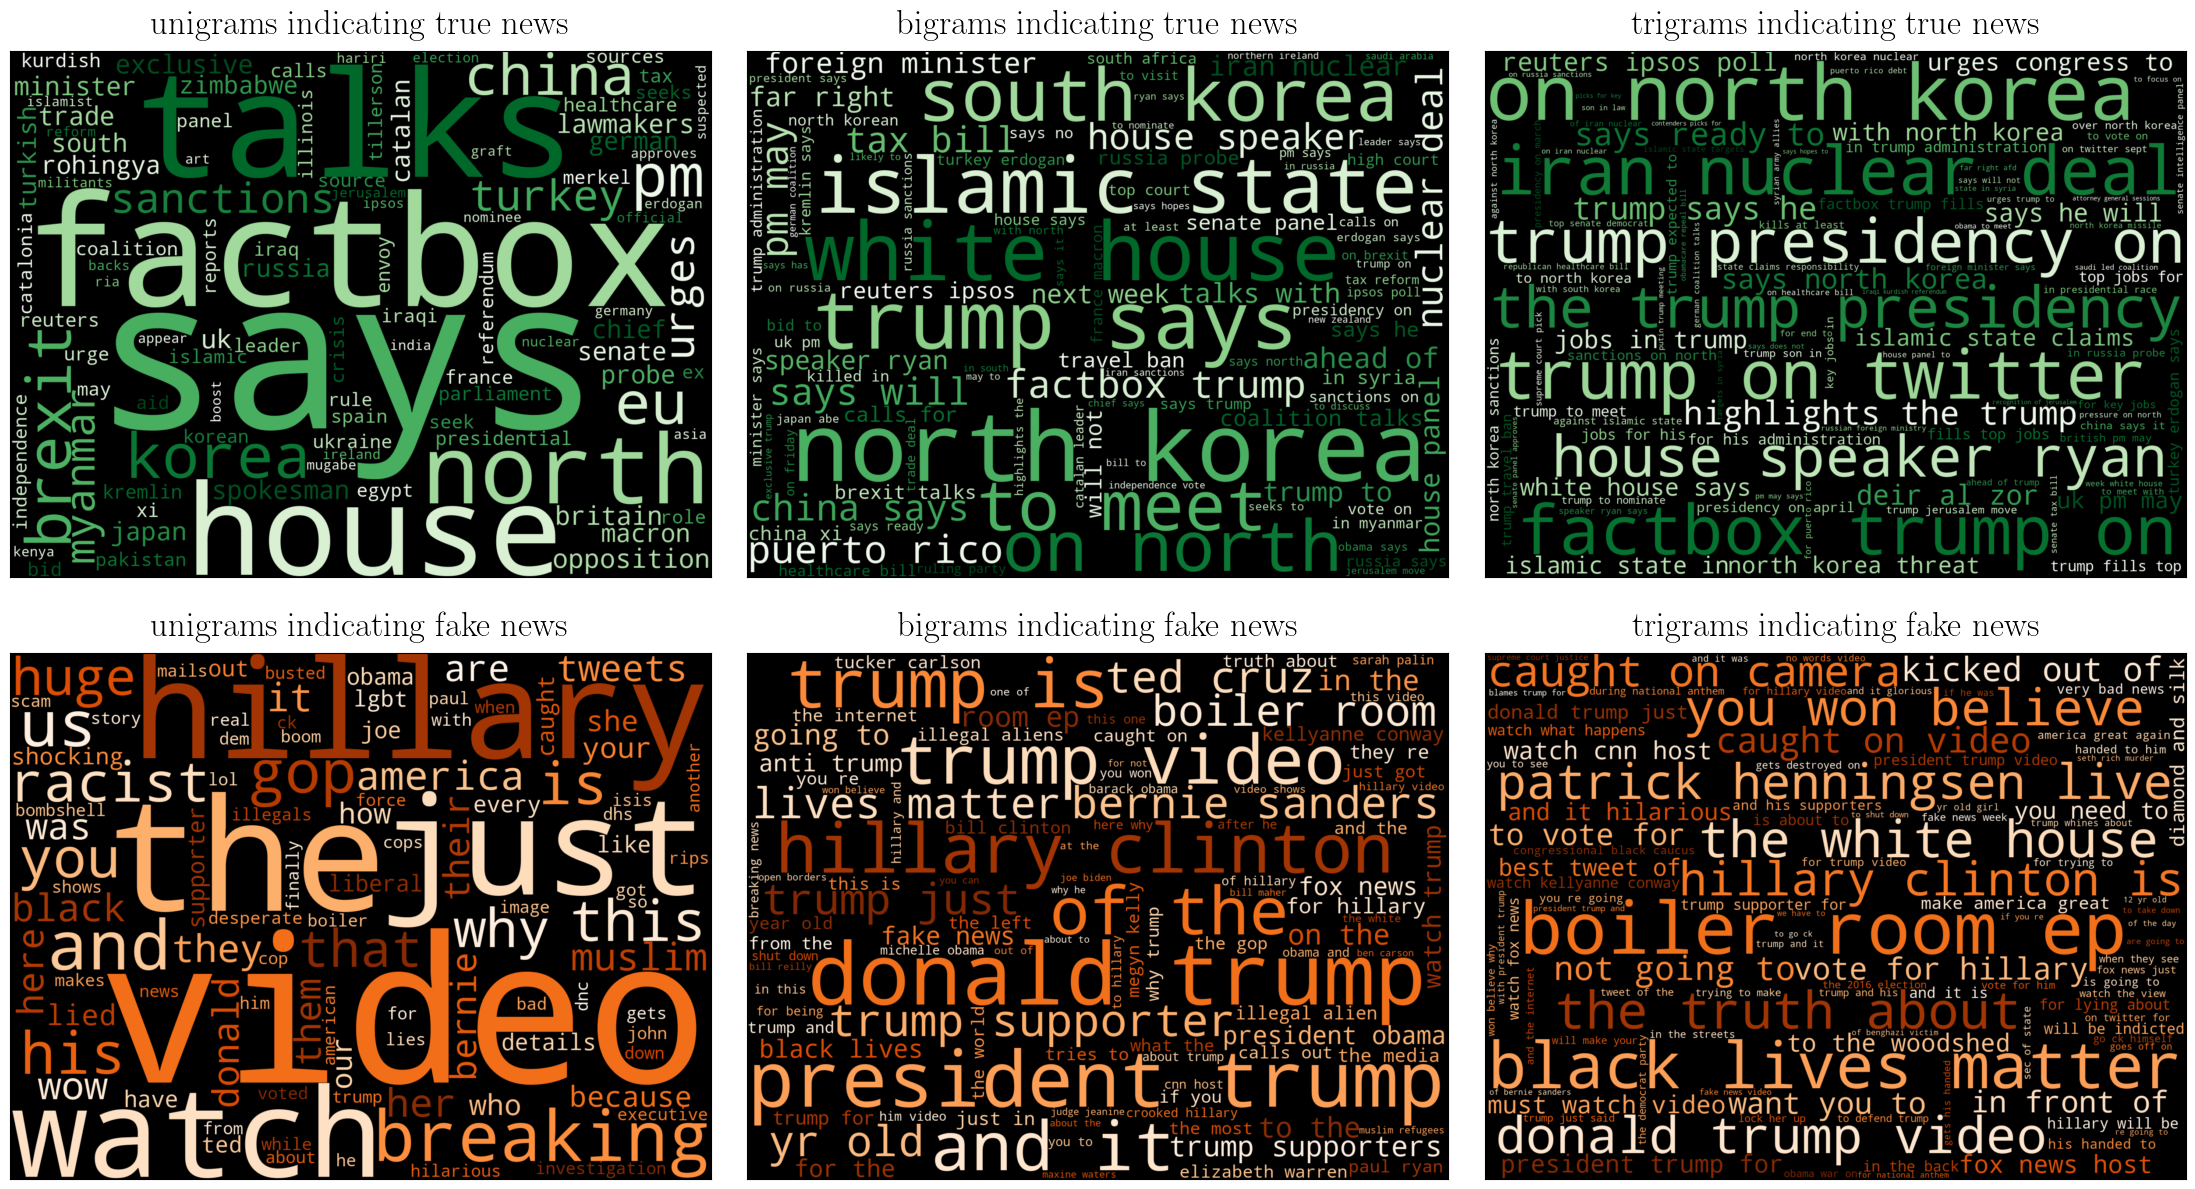

In [53]:
from wordcloud import WordCloud

#wordcloud resolution:
WIDTH=800*2 if SAVE_PLOTS else 800 #reduce resolution for faster computation
HEIGHT=600*2 if SAVE_PLOTS else 600


fig, ax=plt.subplots(2,3, figsize=(25,12))

for i,ngram in enumerate([(1,1), (2,2), (3,3)]): #only plot wordclouds for unigrams resp. bigrams resp. trigrams only
    ngram_name=['unigrams', 'bigrams', 'trigrams'][i] 
    
    #Get feature names and their importance for true/fake news:
    weights_pos=weights[ngram] # positive weights of the model correspond to ngrams indicating true news
    weights_neg=-weights_pos   # negative weights of the model correspond to ngrams indicating fake news
    features=vectorizers[ngram].get_feature_names_out()[columns[0]] # feature names from vectorization with ngrams above
    
    #Create wordclouds
    word_importance_true={word: weight for (word,weight) in zip(features, weights_pos) }  #word (resp ngram) importance for true news
    word_importance_fake={word: weight for (word,weight) in zip(features, weights_neg) } #word (resp ngram) importance for fake news
    wordcloud_true=WordCloud(max_words=100, width=WIDTH, height=HEIGHT, colormap='Greens', random_state=43).generate_from_frequencies(word_importance_true)
    wordcloud_fake=WordCloud(max_words=100, width=WIDTH, height=HEIGHT, colormap='Oranges', random_state=43).generate_from_frequencies(word_importance_fake)
    wordcloud_true.to_svg(embed_font=True, optimize_embedded_font=False) # convert to svg for better quality
    wordcloud_fake.to_svg(embed_font=True, optimize_embedded_font=False) # convert to svg for better quality

    #Plot wordclouds
    ax[0,i].imshow(wordcloud_true, interpolation='bilinear')
    ax[1,i].imshow(wordcloud_fake, interpolation='bilinear')
    
    ax[0,i].set_title(f'{ngram_name} indicating true news', fontsize=25, pad=13)
    ax[1,i].set_title(f'{ngram_name} indicating fake news', fontsize=25,pad=13)
    # Remove ticks
    ax[0,i].set_xticks([]) 
    ax[1,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_yticks([])
    
    plt.tight_layout(h_pad=2.5, w_pad=-4)
    
if SAVE_PLOTS: #save figure
    plt.savefig(f'figures/wordclouds.pdf',dpi=250, format='pdf')
    
